In [276]:
import asyncio
import os
import json

# from dotenv.main import load_dotenv
from dotenv import load_dotenv
from pydantic import BaseModel
from typing import Literal

In [274]:
import chromadb
from langsmith.wrappers import wrap_openai
from langsmith import traceable

from tavily import TavilyClient
from typing_extensions import TypedDict
from openai import OpenAI
from together import AsyncTogether, Together
from chromadb.utils.embedding_functions import OpenAIEmbeddingFunction
from langgraph.graph import END, StateGraph, START, MessagesState

In [3]:
load_dotenv()

True

In [4]:
LANGCHAIN_TRACING_V2 = True
LANGCHAIN_ENDPOINT = "https://api.smith.langchain.com"
LANGCHAIN_PROJECT = "my_test_project"

In [5]:
TOGETHER_API_KEY = os.getenv("TOGETHER_API_KEY")
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")
LANGCHAIN_API_KEY = os.getenv("LANGCHAIN_API_KEY")

In [6]:
EMBEDDING_MODEL = "text-embedding-3-small"
CURR_LLM_MODEL = "meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo"

In [7]:
together_client = wrap_openai(Together(api_key=TOGETHER_API_KEY))
together_client

In [281]:
# async_together_client = wrap_openai(AsyncTogether(api_key=TOGETHER_API_KEY))
async_together_client = AsyncTogether(api_key=TOGETHER_API_KEY)

In [8]:
@traceable
def llm_pipeline(user_input: str) -> str:
    result = together_client.chat.completions.create(
        messages=[{"role": "user", "content": user_input}], model=CURR_LLM_MODEL
    )
    return result.choices[0].message.content

In [282]:
async def async_llm_pipeline(messages):
    tasks = [
        async_together_client.chat.completions.create(
            model=CURR_LLM_MODEL,
            messages=[{"role": "user", "content": message}],
        )
        for message in messages
    ]
    responses = await asyncio.gather(*tasks)

    return [response.choices[0].message.content for response in responses]


In [9]:
llm_pipeline("Hi there. What model are you?")

'I\'m an AI model known as Llama. Llama stands for "Large Language Model Meta AI."'

## CHROMA DB SET UP


In [10]:
embedding_function = OpenAIEmbeddingFunction(
    api_key=OPENAI_API_KEY, model_name=EMBEDDING_MODEL
)
chroma_client = chromadb.Client()

In [11]:
collection = chroma_client.create_collection(
    name="marcus_collection", embedding_function=embedding_function
)

# collection = chroma_client.get_collection(
#     name="marcus_collection", embedding_function=embedding_function
# )

In [12]:
with open("marcus_quotes.txt", "r") as reader:
    marcus_list = reader.readlines()
ids_list = [f"id{i+1}" for i in range(len(marcus_list))]

    

In [13]:
# collection.add(documents=marcus_list, ids=ids_list)

In [14]:
collection.query(
    query_texts=["I want to learn good morals and the government of my temper"],
    n_results=2,
)

{'ids': [[]],
 'embeddings': None,
 'documents': [[]],
 'uris': None,
 'data': None,
 'metadatas': [[]],
 'distances': [[]],
 'included': [<IncludeEnum.distances: 'distances'>,
  <IncludeEnum.documents: 'documents'>,
  <IncludeEnum.metadatas: 'metadatas'>]}

In [15]:
collection.query(
    query_texts=[
        "Я хочу научиться хорошим моральным принципам и управлению моим темпераментом"
    ],
    n_results=1,
)["documents"]

[[]]

## TavilyClient setup


In [17]:
tavily_client = TavilyClient(api_key=TAVILY_API_KEY)

In [18]:
tavily_client.search("Who is Aomine Daiki?")

{'query': 'Who is Aomine Daiki?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': 'Daiki Aomine - Kuroko no Basuke Wiki',
   'url': 'https://kurokonobasuke.fandom.com/wiki/Daiki_Aomine',
   'content': "Daiki Aomine (青峰 大輝 Aomine Daiki) was the ace player of the renowned Generation of Miracles and was the former partner/light of Tetsuya Kuroko in Teikō Junior High. After hearing a benched teammate insult Tetsuya Kuroko and his style of play during a match against Seirin High, Aomine did not hesitate to slam him against the lockers and warn that he, as someone who couldn't even earn a spot on the court, had no right to comment on the players' performances.[5] Aomine was similarly protective over Ryōta Kise following his match against Fukuda Sōgō Academy, as he chose to wait outside the venue to prevent Shōgo Haizaki from causing any further trouble for Kise or his team.[6]",
   'score': 0.9997063,
   'raw_content': None},
  {'title': 'What NBA player 

In [19]:
tavily_client.search("Кто такой Борис Рыжий?", max_results=2)

{'query': 'Кто такой Борис Рыжий?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': 'История легендарного поэта Бориса Рыжего, который прожил всего 26 лет ...',
   'url': 'https://ngs.ru/text/culture/2024/09/09/74062475/',
   'content': 'История поэта Бориса Рыжего, который ушел из жизни в 26 лет и прославился на весь мир История поэта Бориса Рыжего, который ушел из жизни в 26 лет и прославился на весь мир По его словам, Борис Рыжий «был и жил целиком в поэзии, а это\xa0— смертельно». В 1991 году Рыжий пошел по стопам отца и поступил в Свердловский горный институт (на самом деле\xa0— потому что больше было некуда). Писатель Евгений Касимов рассказал E1.RU, что был не так близко знаком с Борисом: несколько раз они работали вместе, делали передачи на радио и ходили друг к другу в гости. Хамство, невежество и мракобесие: врач-педиатр — о том, что его бесит в пациентах Хамство, невежество и мракобесие: врач-педиатр — о том, что его бесит в пациентах',
 

## Prompts for simple function calls


In [236]:
router_prompt = """
    SYSTEM:
    You are an expert at routing a user question to a vectorstore or web search. 
    Vectorstore is consists of the quotes of Marcus Aurelius. If there is an emotion or need for
    an advicce for life situation or just a complain or an advice, 
    use the vectorstore. 
    For all other questions including names, advices on business, weather characters or science use web-search. 
    Give a binary choice 'web_search' or 'vectorstore' based on the question. Return a string with a single word 'web_search' or 'vectorstore' and 
    no premable or explaination. 

    Example:
        Question: I want to learn good morals and the government of my temper.
        Answer: 'vectorstore'

    USER:
    """

In [237]:
stoic_prompt = """
    SYSTEM:
    You are a multilingual string merger. You have a user complain about something emotional in any language.
    You have a tool with a list of closest quotes 
    from Marcus Aurelius. Yus should pick up one closest quote and return it with the prefix 
    "Here is what Marcus Aurelius had to say on this matter:" You must not rephrase the 
    quote or use any thoughts of yours. You must pick one quote. Just prefix and quote no metter what. Answer only in English.

    Example:
        Question: I want to learn good morals and the government of my temper.
        Quotes:["Be not disgusted, nor discouraged, nor dissatisfied,
          if thou dost not succeed in doing everything according to right principles.\n",
  "Examine men's ruling principles, even those of the wise, what kind of things they avoid, and what kind they pursue.\n"]

        Answer: "That is what Marcus Avrelius said on this metter: Be not disgusted, nor discouraged, nor dissatisfied,
          if thou dost not succeed in doing everything according to right principles

    USER:
    """

In [238]:
search_prompt = """
    SYSTEM:
    You are a multilingual search system. you have a qustion from user and a serach results. You need to the closest answer. 
    Answer always in English.

    USER:
    """

In [239]:
curr_question = "What can I do with my shitty life???"

llm_pipeline(f"{router_prompt} {curr_question}")

'vectorstore'

In [240]:
curr_question = "Who is Uzumaki Naruto?"

llm_pipeline(f"{router_prompt} {curr_question}")

'web_search'

## Agentic python functions


In [241]:
def get_search_results(query: str, max_results=2):
    return tavily_client.search(query, max_results=max_results)["results"]

In [242]:
def first_step_completion(user_query):
    return llm_pipeline(f"{router_prompt} {user_query}")

In [243]:
def second_step(first_step_completion, curr_question):
    if first_step_completion == "web_search":
        search_results = get_search_results(curr_question, max_results=2)
        return llm_pipeline(
            f"{search_prompt} {curr_question}, SEARCH_RESULTS: {search_results}"
        )

    elif first_step_completion == "vectorstore":
        store_search = collection.query(query_texts=[curr_question], n_results=2)[
            "documents"
        ]
        return llm_pipeline(f"{stoic_prompt} {curr_question}, QUOTES: {store_search}")

In [244]:
def run_steps(user_query):
    first_step_res = first_step_completion(user_query)
    return second_step(first_step_res, user_query)

In [245]:
run_steps("I want to learn good morals and the government of my temper")

'Here is what Marcus Aurelius said on this matter: Be not disgusted, nor discouraged, nor dissatisfied, if thou dost not succeed in doing everything according to right principles.'

In [246]:
run_steps("Some truths are not for you")

'Here is what Marcus Aurelius had to say on this matter: Some things are too great for us to comprehend.'

In [247]:
run_steps("Shitty life! How to change it???")

'Here is what Marcus Aurelius had to say on this matter: "The impediment to action advances action. What stands in the way becomes the way."'

In [248]:
run_steps("Who is Uzumaki Naruto?")

'Based on the search results, I can tell you that Naruto Uzumaki is the main protagonist of the series "Naruto." He is a genin-level shinobi from the Hidden Leaf Village and is the third and current jinchūriki of Kurama, the Nine-Tails.'

In [249]:
run_steps("Who is Aomine Daiki?")

"Based on the search results, Daiki Aomine is the former ace of the Generation of Miracles and a power forward for Tōō academy's basketball team. He is known for being protective of his teammates, particularly Tetsuya Kuroko and Ryōta Kise."

In [250]:
run_steps("Some truths are not for you")

'Here is what Marcus Aurelius had to say on this matter: Some truths are not for all men, and even among those to whom they are revealed, only a select few are able to grasp them.'

In [251]:
run_steps("How old is Naruto Uzumaki?")

'Based on the search results, I found that Naruto Uzumaki is 12 years old at the beginning of his journey, and his age varies throughout the series. \n\nAt the end of the first part of the series, Naruto is 17 years old. Two years after the events of the Great Ninja War, Naruto is 19 years old.'

In [252]:
run_steps("What happened today with trains between amsterdam and zandfoord?")

'Based on the search results, it appears that there are multiple trains available from Amsterdam to Zandvoort aan Zee, with prices starting from $8.51 for a Standard Class ticket when booked in advance. There are 38 trains per day available for this route.'

In [261]:
run_steps("I don't understand the invoice")

'Here is what Marcus Aurelius had to say on this matter: Be not disgusted, nor discouraged, nor dissatisfied, if thou dost not succeed in doing everything according to right principles.'

### What if there are multiple questions?


In [253]:
tasks_prompt = """
    SYSTEM:
        You are a system, that splits request on topics.
        Analyze the user's request and identify distinct questions or topics within it. Separate each question into its own entry, 
        numbering them sequentially. Use only english language, return result only in JSON format {index: part of the request}.

    EXAMPLE:
        Query:

        Weather is terrible, life shitty. Who is Natsume Souseki and Dostoevsky?

        Model response:
        
        {
        "1": " Weather is terrible",
        "2": "life is shitty",
        "3": "Who is Natsume Souseki?",
        "4": "Who is Natsume Dostoevsky?"
        }


    USER:
    """

In [270]:
def zero_step_completion(user_query):
    result_json = llm_pipeline(f"{tasks_prompt} {user_query}")
    return json.loads(result_json)

In [271]:
def run_multitasks(user_query):
    res_list = []
    
    for task in zero_step_completion(user_query).values():
        res_list.append(run_steps(task))

    return res_list

In [272]:
run_multitasks("Whaaaat What is the weather atm, I don't understand the invoice btw? My life is shitty, and who is Ukio Mishima?")

['Based on the search results, the closest answer to the question "What is the weather atm?" is:\n\nThe current weather is Cloudy with a temperature of 25.8°C (78.5°F) in Harbour Island, Bahamas.',
 'Here is what Marcus Aurelius had to say on this matter: Be not disgusted, nor discouraged, nor dissatisfied, if thou dost not succeed in doing everything according to right principles.',
 'Here is what Marcus Aurelius had to say on this matter: "The impediment to action advances action. What stands in the way becomes the way."',
 'Based on the search results, the closest answer to the question "Who is Yukio Mishima?" is:\n\nYukio Mishima was a Japanese author born in 1925 in Tokyo. He graduated from Tokyo Imperial University\'s School of Jurisprudence in 1947 and established himself as a major author with his works including "Confessions of a Mask" (1949).']

In [283]:
# async def a_zero_step_completion(user_queries):
#     queries_list = [f"{tasks_prompt} {user_query}" for user_query in user_queries]
#     result_json_list = await async_llm_pipeline(queries_list)
#     return [json.loads(result_json) for result_json in result_json_list]

In [1]:
# await a_zero_step_completion("Whaaaat What is the weather atm, I don't understand the invoice btw? My life is shitty, and who is Ukio Mishima?")


In [256]:
async def a_first_step_completion(user_query):
    return llm_pipeline(f"{router_prompt} {user_query}")

In [257]:
async def a_second_step_completion(first_step_completion, curr_question):
    if first_step_completion == "web_search":
        search_results = get_search_results(curr_question, max_results=2)
        return llm_pipeline(
            f"{search_prompt} {curr_question}, SEARCH_RESULTS: {search_results}"
        )

    elif first_step_completion == "vectorstore":
        store_search = collection.query(query_texts=[curr_question], n_results=2)[
            "documents"
        ]
        return llm_pipeline(f"{stoic_prompt} {curr_question}, QUOTES: {store_search}")

In [258]:
await a_zero_step_completion("Whaaaat What is the weather atm, I don't understand the invoice btw? My life is shitty, and who is Ukio Mishima?")

{'1': 'What is the weather atm?',
 '2': "I don't understand the invoice",
 '3': 'My life is shitty',
 '4': 'Who is Ukio Mishima?'}

In [265]:
async def run_steps_v2(user_query):
    results_list = []
    results_cors_list = []
    tool_cors_list = []


    tasks_dict = await a_zero_step_completion(user_query)
    for task in tasks_dict.values():
        tool_cors_list.append(a_first_step_completion(task))

    tools_list = await asyncio.gather(*tool_cors_list)
    for ind, tool_name in enumerate(tools_list):
        results_cors_list.append(a_second_step_completion(tool_name, list(tasks_dict.values())[ind]))

    results_list = await asyncio.gather(*results_cors_list)
    results_list = map(lambda x, y: f"Question: {x}, Answer: {y}", tasks_dict.values(), results_list)
    return list(results_list)

In [266]:
await run_steps_v2("Whaaaat What is the weather atm, I don't understand the invoice btw? My life is shitty, and who is Ukio Mishima?")

['Based on the search results, I found the following information about the current weather:\n\nThe current weather in Harbour Island, Bahamas is Cloudy with a temperature of 25.8°C (78.5°F) and a humidity of 73%. The wind speed is 31.7 km/h (19.7 mph) from the northeast direction.', 'Here is what Marcus Aurelius had to say on this matter: Be not disgusted, nor discouraged, nor dissatisfied, if thou dost not succeed in doing everything according to right principles.', 'Here is what Marcus Aurelius had to say on this matter: "The impediment to action advances action. What stands in the way becomes the way."', 'Based on the search results, the closest answer to the question "Who is Ukio Mishima?" is:\n\nYukio Mishima, a Japanese author, was a prolific writer who is regarded by many critics as the most important Japanese novelist of the 20th century.'] ['web_search', 'vectorstore', 'vectorstore', 'web_search']


['Question: What is the weather atm?, Answer: Based on the search results, I found the following information about the current weather:\n\nThe current weather in Harbour Island, Bahamas is Cloudy with a temperature of 25.8°C (78.5°F) and a humidity of 73%. The wind speed is 31.7 km/h (19.7 mph) from the northeast direction.',
 "Question: I don't understand the invoice, Answer: Here is what Marcus Aurelius had to say on this matter: Be not disgusted, nor discouraged, nor dissatisfied, if thou dost not succeed in doing everything according to right principles.",
 'Question: My life is shitty, Answer: Here is what Marcus Aurelius had to say on this matter: "The impediment to action advances action. What stands in the way becomes the way."',
 'Question: Who is Ukio Mishima?, Answer: Based on the search results, the closest answer to the question "Who is Ukio Mishima?" is:\n\nYukio Mishima, a Japanese author, was a prolific writer who is regarded by many critics as the most important Japane

## Let's try Langgraph + LangChain classes


In [37]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool

In [38]:
@tool
def stoic_collection_search(query, n_results=4) -> dict:
    """
    Searches a stoic quote in a collection. Use when needed advice on an emotional or life-relational situation.
    """

    return collection.query(
        query_texts=[query],
        n_results=n_results,
    )  # type: ignore

In [39]:
from typing import Optional, Type

from pydantic import Field


class SearchInput(BaseModel):
    query: str = Field(description="should be a search query")


class CustomStoicSearchTool:
    name = "stoic_collection_search"
    description = "Searches a stoic quote in a collection. Use when needed advice on an emotional or life-relational situation."
    title = "stoic_collection_search"
    # args_schema: Type[BaseModel] = SearchInput

    def _run(query, n_results=4) -> dict:
        """Use the tool."""
        return collection.query(
            query_texts=[query],  # type: ignore
            n_results=n_results,
        )

In [40]:
stoic_collection_search.name  # remember kwargs lag

'stoic_collection_search'

In [41]:
my_stoic_collection_search = CustomStoicSearchTool()

In [42]:
my_stoic_collection_search.name

'stoic_collection_search'

In [43]:
# from langchain.tools.retriever import create_retriever_tool

# retriever_tool = create_retriever_tool(
#     retriever,
#     "retrieve_blog_posts",
#     "Search and return information about Lilian Weng blog posts on LLM agents, prompt engineering, and adversarial attacks on LLMs.",
# )

In [44]:
search_tool = TavilySearchResults(max_results=4)


In [45]:
tools = [stoic_collection_search, search_tool]
# tools = [my_stoic_collection_search, search_tool]

In [46]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

In [47]:
class LgAgent:

    def __init__(self, model, tools, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_openai)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges(
            "llm", self.exists_action, {True: "action", False: END}
        )
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile()
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def exists_action(self, state: AgentState):
        result = state["messages"][-1]
        return len(result.tool_calls) > 0

    def call_openai(self, state: AgentState):
        messages = state["messages"]
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {"messages": [message]}

    def take_action(self, state: AgentState):
        tool_calls = state["messages"][-1].tool_calls
        results = []
        for tool in tool_calls:
            print(f"Calling: {tool}")
            if not tool["name"] in self.tools:  # check for bad tool name from LLM
                print("\n ....bad tool name....")
                result = "bad tool name, retry"  # instruct LLM to retry if bad
            else:
                result = self.tools[tool["name"]].invoke(tool["args"])
            results.append(
                ToolMessage(
                    tool_call_id=tool["id"], name=tool["name"], content=str(result)
                )
            )
        print("Back to the model!")
        return {"messages": results}

In [48]:
prompt = """You are a smart ass research assistant. You are an expert at routing a user question to a stoic_collection_search or web search. 
    stoic_collection_search is consists of the stoic quotes. 
    
    If there is an emotion or need for
    an advice for life situation or just a complain or an advice, 
    use the stoic_collection_search. You should pick up a most appropriate one quote and return it with the prefix 
    "Here is what Marcus Aurelius had to say on this matter:" You must not rephrase the 
    quote or use any thoughts of yours. Just prefix and quote no metter what.


    For all other questions use web-search
    If you need to look up some information before asking a follow up question, you are allowed to do that!  Answer only in English. 
"""

In [49]:
model = ChatOpenAI(model="gpt-3.5-turbo")  # reduce inference cost
abot = LgAgent(model, tools, system=prompt)

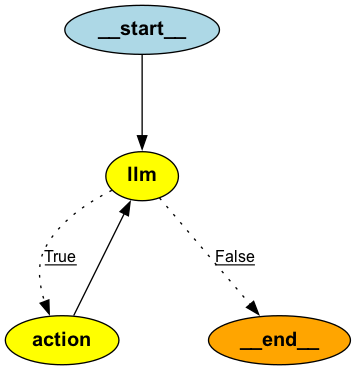

In [50]:
from IPython.display import Image

Image(abot.graph.get_graph().draw_png())

In [51]:
messages = [HumanMessage(content="What is the weather in utrecht this sunday?")]
messages = abot.graph.invoke({"messages": messages})
print(messages)
messages["messages"][-1].content

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather forecast Utrecht Sunday'}, 'id': 'call_Lmkdc0ww8j1eiBFhWE7qy2tg', 'type': 'tool_call'}
Back to the model!
{'messages': [HumanMessage(content='What is the weather in utrecht this sunday?', additional_kwargs={}, response_metadata={}), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Lmkdc0ww8j1eiBFhWE7qy2tg', 'function': {'arguments': '{"query":"weather forecast Utrecht Sunday"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 311, 'total_tokens': 333, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-3c09246c-dec2-4773-9387-2ab8d9a1e34d-0', tool_calls=[{'name': 'tavily_sea

'I found the weather forecast for Utrecht this Sunday. It is expected to be partly cloudy with a temperature of around 9.3°C (48.7°F).'

In [52]:
messages = [HumanMessage(content="Shitty life")]
messages = abot.graph.invoke({"messages": messages})
print(messages)
messages["messages"][-1].content

Calling: {'name': 'stoic_collection_search', 'args': {'query': 'shitty life'}, 'id': 'call_71AtBl4jTqZGyR9wzx0igK4U', 'type': 'tool_call'}
Back to the model!
{'messages': [HumanMessage(content='Shitty life', additional_kwargs={}, response_metadata={}), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_71AtBl4jTqZGyR9wzx0igK4U', 'function': {'arguments': '{"query":"shitty life"}', 'name': 'stoic_collection_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 305, 'total_tokens': 324, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-7b1ee023-de3d-4518-9cde-c361314dedc4-0', tool_calls=[{'name': 'stoic_collection_search', 'args': {'query': 'shitty life'}, 'id': 'call_71AtBl4jTqZGyR9w

'I couldn\'t find a specific quote related to "shitty life" in the Stoic collection. Would you like me to search the web for some advice or information on dealing with difficult situations in life?'

In [53]:
messages = [
    HumanMessage(content="I want to learn good morals and the government of my temper")
]
messages = abot.graph.invoke({"messages": messages})
print(messages)
messages["messages"][-1].content

Calling: {'name': 'stoic_collection_search', 'args': {'query': 'good morals and self-control'}, 'id': 'call_1YHWJhdYuz4gJmfnnWIgTVAE', 'type': 'tool_call'}
Back to the model!
{'messages': [HumanMessage(content='I want to learn good morals and the government of my temper', additional_kwargs={}, response_metadata={}), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_1YHWJhdYuz4gJmfnnWIgTVAE', 'function': {'arguments': '{"query":"good morals and self-control"}', 'name': 'stoic_collection_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 314, 'total_tokens': 335, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-73089ce6-e66e-473f-815a-c8a6e0eb9965-0', tool_calls=[{'name': 'stoic_

"I couldn't find a specific quote on good morals and self-control in the Stoic collection. Would you like me to search the web for information on this topic?"

In [54]:
messages = [HumanMessage(content="Who is Aomine Daiki?")]
messages = abot.graph.invoke({"messages": messages})
print(messages)
messages["messages"][-1].content

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Aomine Daiki'}, 'id': 'call_TsGhRpsdlpfCCKJAk5dRhr94', 'type': 'tool_call'}
Back to the model!
{'messages': [HumanMessage(content='Who is Aomine Daiki?', additional_kwargs={}, response_metadata={}), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_TsGhRpsdlpfCCKJAk5dRhr94', 'function': {'arguments': '{"query":"Aomine Daiki"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 310, 'total_tokens': 332, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-064eed88-4a55-4f2d-a584-ed9452010905-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Aomine Daiki'}, 'id': '

'Aomine Daiki is a character from the anime series "Kuroko no Basket." He was the ace player of the renowned Generation of Miracles and the former partner of Tetsuya Kuroko in Teikō Junior High. Aomine is known for his strong skills and protective nature towards his teammates.'

In [55]:
messages = [HumanMessage(content="How old is Naruto Uzumaki?")]
messages = abot.graph.invoke({"messages": messages})
print(messages)
messages["messages"][-1].content

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Naruto Uzumaki age'}, 'id': 'call_DKhFSyZD4r2If39D7FjguR0T', 'type': 'tool_call'}
Back to the model!
{'messages': [HumanMessage(content='How old is Naruto Uzumaki?', additional_kwargs={}, response_metadata={}), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_DKhFSyZD4r2If39D7FjguR0T', 'function': {'arguments': '{"query":"Naruto Uzumaki age"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 311, 'total_tokens': 336, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-84fb3d18-ad30-4517-9034-d94b501b35b8-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Narut

'Naruto Uzumaki starts off his long journey as a tween, 12 years old to be exact. By the end of the first arc, Naruto is 17 years old. However, the majority of the main action takes place two years after the events of the Great Ninja War, making Naruto and most of his friends 19 years old.'

In [56]:
messages = [
    HumanMessage(
        content="What happened today with trains between amsterdam and zandfoord?"
    )
]
messages = abot.graph.invoke({"messages": messages})
print(messages)
messages["messages"][-1].content

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'train delay between Amsterdam and Zandvoort today'}, 'id': 'call_gBptQgDdJNe8c9mOHIG3f4cW', 'type': 'tool_call'}
Back to the model!
{'messages': [HumanMessage(content='What happened today with trains between amsterdam and zandfoord?', additional_kwargs={}, response_metadata={}), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_gBptQgDdJNe8c9mOHIG3f4cW', 'function': {'arguments': '{"query":"train delay between Amsterdam and Zandvoort today"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 315, 'total_tokens': 342, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-6a825333-4dc6-43

"I couldn't find any specific information on train delays between Amsterdam and Zandvoort today. Trains usually run hourly between the two locations with an average travel time of 30 minutes."

LlamaIndex


In [57]:
from llama_index.core.agent import ReActAgent
from llama_index.core.tools import FunctionTool
from llama_index.llms.together import TogetherLLM

/Users/dmitrykutsev/repos/learn_langgraph/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [58]:
llm = TogetherLLM(
    model=CURR_LLM_MODEL,
    api_key=TOGETHER_API_KEY,
)

In [59]:
def li_stoic_collection_search(query, n_results=4) -> dict:
    """
    Searches a stoic quote in a collection. Use when needed advice on an emotional or life-relational situation.
    The closest quote is the answer.cUse only the quote without changing.
    The response should begin with ‘Here is what Marcus Aurelius had to say on this matter.’”
    """

    return collection.query(
        query_texts=[query],
        n_results=n_results,
    )  # type: ignore

In [60]:
def li_tavily_search(query, n_results=4) -> dict:
    """
    Conduct a search on the topic of [user's query topic] and provide a concise, accurate summary based on the most relevant results
    """
    return tavily_client.search(query, max_results=n_results)

In [61]:
li_tavily_tool = FunctionTool.from_defaults(fn=li_tavily_search)
li_stoic_collection_tool = FunctionTool.from_defaults(fn=li_stoic_collection_search)

In [62]:
agent = ReActAgent.from_tools(
    [li_tavily_tool, li_stoic_collection_tool], llm=llm, verbose=True
)

In [64]:
agent.chat("How old is Naruto Uzumaki?")

> Running step 98a9997f-e8f9-4498-b82b-b12cf4d012fb. Step input: How old is Naruto Uzumaki?
Thought: The current language of the user is English. I need to use a tool to help me answer the question.
Action: li_tavily_search
Action Input: {'query': 'Naruto Uzumaki age', 'n_results': 1}
Observation: {'query': 'Naruto Uzumaki age', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'title': "How old is Naruto? Naruto Uzumaki's age throughout his namesake ...", 'url': 'https://wegotthiscovered.com/anime/how-old-is-naruto-naruto-uzumakis-age-throughout-his-namesake-franchise-explained/', 'content': 'How Old Is Naruto? How old is Naruto? Naruto Uzumaki starts off his long journey as a tween, 12 years old to be exact. Airing from 2002 to 2007, the first part of the Naruto series showcases the protagonist as a pre-teen, from 12 to 13 years old. By the end of this arc, Naruto and Jiraya begin their return trip to the Leaf Village after nearly three years away. By the end, N

AgentChatResponse(response='Naruto Uzumaki is 19 years old at the end of the series.', sources=[ToolOutput(content='{\'query\': \'Naruto Uzumaki age\', \'follow_up_questions\': None, \'answer\': None, \'images\': [], \'results\': [{\'title\': "How old is Naruto? Naruto Uzumaki\'s age throughout his namesake ...", \'url\': \'https://wegotthiscovered.com/anime/how-old-is-naruto-naruto-uzumakis-age-throughout-his-namesake-franchise-explained/\', \'content\': \'How Old Is Naruto? How old is Naruto? Naruto Uzumaki starts off his long journey as a tween, 12 years old to be exact. Airing from 2002 to 2007, the first part of the Naruto series showcases the protagonist as a pre-teen, from 12 to 13 years old. By the end of this arc, Naruto and Jiraya begin their return trip to the Leaf Village after nearly three years away. By the end, Naruto is 17 years old and has undergone an epic journey from zero to hero. In The Last: Naruto the Movie But the majority of the main action takes place two year

In [92]:
agent.chat("Shitty life! How to change it???")

> Running step a362c71c-530b-4e55-9a56-c4c834c15ee2. Step input: Shitty life! How to change it???
Thought: The current language of the user is: English. I need to use a tool to help me answer the question.
Action: li_stoic_collection_search
Action Input: {'query': 'change a shitty life', 'n_results': 1}
Observation: {'ids': [[]], 'embeddings': None, 'documents': [[]], 'uris': None, 'data': None, 'metadatas': [[]], 'distances': [[]], 'included': [<IncludeEnum.distances: 'distances'>, <IncludeEnum.documents: 'documents'>, <IncludeEnum.metadatas: 'metadatas'>]}
> Running step 71f7aa6c-d1aa-4e89-81fd-099a0c145bdc. Step input: None
Thought: The previous tool response was not what I expected. I'll try again with a different tool.
Action: li_tavily_search
Action Input: {'query': 'change a shitty life', 'n_results': 1}
Observation: {'query': 'change a shitty life', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'title': '24 Things You Can Do To Change Your Life For The

AgentChatResponse(response="It seems like you're feeling stuck in a difficult situation. To change your life for the better, consider making a list of the things you want to change and consult a life coach for guidance. Sometimes, just acknowledging what needs to be changed can be a powerful step towards making positive changes.", sources=[ToolOutput(content="{'ids': [[]], 'embeddings': None, 'documents': [[]], 'uris': None, 'data': None, 'metadatas': [[]], 'distances': [[]], 'included': [<IncludeEnum.distances: 'distances'>, <IncludeEnum.documents: 'documents'>, <IncludeEnum.metadatas: 'metadatas'>]}", tool_name='li_stoic_collection_search', raw_input={'args': (), 'kwargs': {'query': 'change a shitty life', 'n_results': 1}}, raw_output={'ids': [[]], 'embeddings': None, 'documents': [[]], 'uris': None, 'data': None, 'metadatas': [[]], 'distances': [[]], 'included': [<IncludeEnum.distances: 'distances'>, <IncludeEnum.documents: 'documents'>, <IncludeEnum.metadatas: 'metadatas'>]}, is_er

In [84]:
agent.chat("Who is Aomine Daiki?")

> Running step d4551bb8-8773-4fb7-a4c2-d08196afebed. Step input: Who is Aomine Daiki?
Thought: I need to find information about Aomine Daiki.
Action: li_tavily_search
Action Input: {'query': 'Aomine Daiki', 'n_results': 4}
Observation: {'query': 'Aomine Daiki', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'title': 'Daiki Aomine - Kuroko no Basuke Wiki', 'url': 'https://kurokonobasuke.fandom.com/wiki/Daiki_Aomine', 'content': "Daiki Aomine (青峰 大輝 Aomine Daiki) was the ace player of the renowned Generation of Miracles and was the former partner/light of Tetsuya Kuroko in Teikō Junior High. After hearing a benched teammate insult Tetsuya Kuroko and his style of play during a match against Seirin High, Aomine did not hesitate to slam him against the lockers and warn that he, as someone who couldn't even earn a spot on the court, had no right to comment on the players' performances.[5] Aomine was similarly protective over Ryōta Kise following his match against Fuk

AgentChatResponse(response='Aomine Daiki is a character from the anime series "Kuroko no Basket". He is the ace player of the Generation of Miracles and was the former partner of Tetsuya Kuroko in Teikō Junior High. He is known for being protective of his teammates and having a short temper.', sources=[ToolOutput(content='{\'query\': \'Aomine Daiki\', \'follow_up_questions\': None, \'answer\': None, \'images\': [], \'results\': [{\'title\': \'Daiki Aomine - Kuroko no Basuke Wiki\', \'url\': \'https://kurokonobasuke.fandom.com/wiki/Daiki_Aomine\', \'content\': "Daiki Aomine (青峰 大輝 Aomine Daiki) was the ace player of the renowned Generation of Miracles and was the former partner/light of Tetsuya Kuroko in Teikō Junior High. After hearing a benched teammate insult Tetsuya Kuroko and his style of play during a match against Seirin High, Aomine did not hesitate to slam him against the lockers and warn that he, as someone who couldn\'t even earn a spot on the court, had no right to comment o

In [65]:
from llama_index.core.workflow import (
    StartEvent,
    StopEvent,
    Workflow,
    step,
)

In [66]:
# from llama_index.utils.workflow import draw_all_possible_flows
from llama_index.utils.workflow import draw_all_possible_flows

In [68]:
class MyWorkflow(Workflow):
    @step
    async def my_step(self, ev: StartEvent) -> StopEvent:
        # do something here
        return StopEvent(result="Hello, world!")


w = MyWorkflow(timeout=10, verbose=False)
result = await w.run()
print(result)

Hello, world!


In [69]:
draw_all_possible_flows(MyWorkflow, filename="basic_workflow.html")

<class 'NoneType'>
<class 'llama_index.core.workflow.events.StopEvent'>
basic_workflow.html
